# Description
Notebook to create figures in the paper: "Continuity between ancient geochemistry and modern metabolism enabled by non-autocatalytic purine biosynthesis" by Goldford, J.E., Smith, H.B., Longo, L.M. Wing, B.A. & McGlynn, S.M.

### Load packages

In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'
import pingouin as pg


def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
metabolism = load_data('metabolism.23Aug2022.pkl')
cids = metabolism.coenzymes

In [102]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

### Run network expansion

In [2]:
seed_set = pd.read_csv('assets/seed_set.csv')['ID'].tolist()

print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])


There were 70 compounds in this seed set...


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:533: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)


There were 4311 compounds produced in this expansion!


### Figure 1A. Run network expansion w/o non-autocatalytic purine biosynthesis +/- adenine, and plot traces

/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:533: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:533: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:533: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  X,Y = netExp_trace(R,P,x0,b)


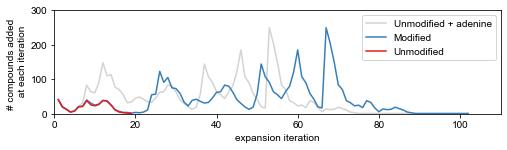

In [4]:
# now remove purine production 
metab_unmod = metabolism.copy()
ne_cpds,ne_rxns = metab_unmod.expand(seed_set,algorithm='trace')
rn_to_remove = [x for x in metab_unmod.network.rn.unique().tolist() if (('_gATP' in x) or ('_gGTP' in x))]
metab_unmod.network = metab_unmod.network[~metab_unmod.network.rn.isin(rn_to_remove)]
ne_cpds_np,ne_rxns_np = metab_unmod.expand(seed_set,algorithm='trace')
ne_cpds_np_ad,ne_rxns_np_ad = metab_unmod.expand(seed_set + ['C00147'],algorithm='trace')


cmap = sns.color_palette("Set1")
abun = pd.DataFrame(pd.Series(ne_cpds),columns=['iter']).reset_index().groupby('iter').count()
abun['compounds (cumulative)'] = abun['index'].cumsum()

abun_alt = pd.DataFrame(pd.Series(ne_cpds_np),columns=['iter']).reset_index().groupby('iter').count()
abun_alt['compounds (cumulative)'] = abun_alt['index'].cumsum()

abun_ad = pd.DataFrame(pd.Series(ne_cpds_np_ad),columns=['iter']).reset_index().groupby('iter').count()
abun_ad['compounds (cumulative)'] = abun_ad['index'].cumsum()

#sns.scatterplot(x='iter',y='compounds (cumulative)',data=abun)
plt.figure(figsize=(8,4/14*8))
sns.lineplot(x='iter',y='index',data=abun_ad.iloc[1:],color='lightgrey')
sns.lineplot(x='iter',y='index',data=abun.iloc[1:],color=cmap[1])
sns.lineplot(x='iter',y='index',data=abun_alt.iloc[1:],color=cmap[0])


plt.ylabel('# compounds added \n at each iteration')
plt.xlabel("expansion iteration")
plt.xlim([0,110])
plt.ylim([0,300])
plt.subplots_adjust(bottom=0.25)
plt.legend(['Unmodified + adenine','Modified','Unmodified'])

### Fig 3A: average molecular complexity vs. expansion iteration

Text(0.1, 0.75, '$r=0.73$ \n$P<10^{-17}$')

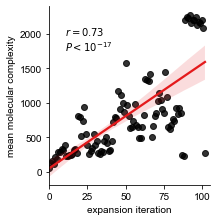

In [5]:
skws={"color": "black"}
lkws={'color': cmap[0]}
complexity = pd.read_csv('assets/kegg_cpds.iterationComplexity.csv',index_col=0)
complexity = complexity[['complexity']].join(pd.DataFrame(pd.Series(ne_cpds),columns=['iteration']))
sns.lmplot(x='iteration',y='complexity',data=complexity.groupby('iteration').mean().reset_index(),height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlim([0,105])
plt.ylabel('mean molecular complexity')
plt.xlabel('expansion iteration')
c = complexity.groupby('iteration').mean().reset_index()


r,pval = pearsonr(c['iteration'].values,c['complexity'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.75), xycoords='axes fraction')

### Fig 3B: average genome representation vs. expansion iteration

Text(0.1, 0.1, '$r=-0.81$ \n$P<10^{-23}$')

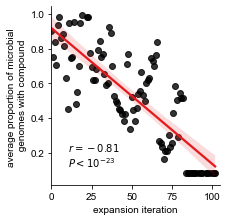

In [6]:
cpd_df = pd.DataFrame(pd.Series(ne_cpds)).reset_index()
cpd_df.columns = ['cid','iteration']
md2cpd = pd.read_csv('assets/KEGG_ModuleVsCompound.csv')
kegg_modules = pd.read_csv('assets/KEGG_GenomesToModule.csv')
genome_cids = kegg_modules.set_index('module').join(md2cpd.set_index('module'))[['genome','cid']].drop_duplicates()
genome_cids['count'] = 1
genome_cids_counts = genome_cids.groupby('cid').sum()
N = len(kegg_modules.genome.unique())
ne_genomes_cid = genome_cids_counts.join(cpd_df.set_index('cid'))
ne_genomes_cid['genome_percentage']= ne_genomes_cid['count'] / N
ne_genomes_cid['expansion'] = ~ne_genomes_cid.iteration.isna()
q = ne_genomes_cid.dropna().groupby('iteration').mean().reset_index()


skws={"color": "black"}
lkws={'color': cmap[0]}

sns.lmplot(x='iteration',y='genome_percentage',data=q,height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlabel('expansion iteration')
plt.ylabel('average proportion of microbial \n genomes with compound')

plt.xlim([0,105])


r,pval = pearsonr(q['iteration'].values,q['genome_percentage'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.1), xycoords='axes fraction')


### Fig 3C: proportion of metal usage vs. expansion iteration

-0.7442299044912474
2.0944267383797933e-19


Text(0.6, 0.75, '$r=-0.74$ \n$P<10^{-18}$')

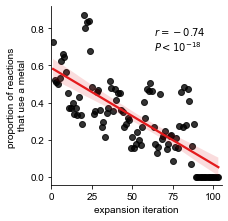

In [7]:
# compute the fraction of each iteration that uses a metal

# determine proportion of reactions per iteration that use CO2 as reductant
rns_tmp = pd.Series(ne_rxns).reset_index()
rns_tmp.columns = ['reaction','direction','iteration']
mtls = cids[cids['Coenzyme type/function'].isin(['Iron sulfur','Metal','Metal monovalent'])].ZID.tolist()

metal_using_reactions = metabolism.network[(metabolism.network.cid.isin(mtls))][['rn','direction']].drop_duplicates()
metal_using_reactions = metal_using_reactions.apply(tuple,axis=1).tolist()
z = rns_tmp[['reaction','direction']].apply(tuple, axis=1).apply(lambda x: x in metal_using_reactions)
rns_tmp['cofactor_usage'] = z
rns_tmp['total'] = 1
rz = rns_tmp.groupby('iteration').sum()
rz = rz['cofactor_usage'] / rz['total']

prop = pd.DataFrame(rz,columns = ['prop'])
sns.lmplot(x='iteration',y='prop',data=prop.reset_index(),height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlim([0,105])
plt.xlabel('expansion iteration')
plt.ylabel('proportion of reactions \n that use a metal')

r,pval = pearsonr(prop.reset_index()['iteration'].values,prop.reset_index()['prop'].values)
print(r)
print(pval)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.6, 0.75), xycoords='axes fraction')


### Fig 3D: average fold symmetry score vs. expansion number

Text(0.1, 0.1, '$r=-0.7$ \n$P<10^{-15}$')

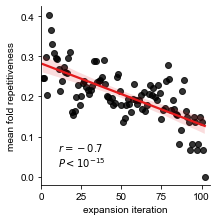

In [8]:
fold2rxns = pd.read_csv('assets/fold2rxn.ec.30Aug2022.p20.csv',index_col=0)
fold2rxns.columns = ['rn','rule']
fold2rxns['rule'] = fold2rxns.rule.apply(lambda x: str(x))
fold_sym = pd.read_csv("assets/xgroup_symmetry.txt",sep=',',header=None)
fold_sym = fold_sym[[0,1,2]]
fold_sym.columns = ['Fold','Symmmetry','Score']
fold_sym['Fold'] = fold_sym.Fold.apply(lambda x: str(x))

rn_folds = {'rn':[],'folds':[]}
for rn, dff in fold2rxns.groupby('rn'):
    folds = dff.rule.apply(lambda x: x.split('_')).tolist()
    F = []
    for f in folds:
        for ff in f:
            F.append(ff)
    F = set(F)
    rn_folds['rn'].append(rn)
    rn_folds['folds'].append(list(F))
    
rn_folds = pd.DataFrame(rn_folds)
rn_folds['average sym'] = rn_folds.folds.apply(lambda x: fold_sym[fold_sym.Fold.isin(x)].Score.mean())
rn_folds = rn_folds.dropna()
rn_folds['X-groups'] = rn_folds['folds'].apply(lambda x: ";".join(x))


scores = {'iteration': [] ,'mean_symmetry_score': []}

for iteration,dff in pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration']).groupby('iteration'):
    g = [x[0] for x in dff.index.tolist()]
    g = [x.split('_')[0] for x in g]
    scores['iteration'].append(iteration)
    s = rn_folds[rn_folds.rn.isin(g)]['average sym'].mean()
    scores['mean_symmetry_score'].append(s)
    
scores = pd.DataFrame(scores)
scores = scores.dropna()

sns.lmplot(x='iteration',y='mean_symmetry_score',data=scores,height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlim([0,105])
plt.ylabel('mean fold repetitiveness')
plt.xlabel('expansion iteration')


r,pval = pearsonr(scores['iteration'].values,scores['mean_symmetry_score'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.1), xycoords='axes fraction')


In [39]:
cpd_dor = cpd_df.set_index("cid").join(dor.set_index("cid")[["reduction"]]).dropna()

Text(0.1, 0.1, '$r=0.89$ \n$P<10^{-27}$')

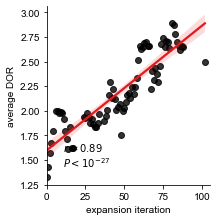

In [42]:
dor = pd.read_csv("assets/keggCHOmolecules.reductionState.csv")
cpd_dor = cpd_df.set_index("cid").join(dor.set_index("cid")[["reduction"]]).dropna()

cpd_dor_mean = cpd_dor.dropna().groupby('iteration').mean().reset_index()


skws={"color": "black"}
lkws={'color': cmap[0]}

sns.lmplot(x='iteration',y='reduction',data=cpd_dor_mean,height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlabel('expansion iteration')
plt.ylabel('average DOR')

plt.xlim([0,105])

r,pval = pearsonr(cpd_dor_mean['iteration'].values,cpd_dor_mean['reduction'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.1), xycoords='axes fraction')


In [14]:
prop.columns = ["metal-usage"]
scores.set_index("iteration",inplace=True)
genome_percentage= q.set_index("iteration")[["genome_percentage"]]
mean_complexity = c.set_index("iteration")

In [45]:
all_metrics = prop.join(scores).join(genome_percentage).join(mean_complexity).dropna()
all_metrics = all_metrics.join(cpd_dor_mean.set_index("iteration"))

/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x432 with 0 Axes>

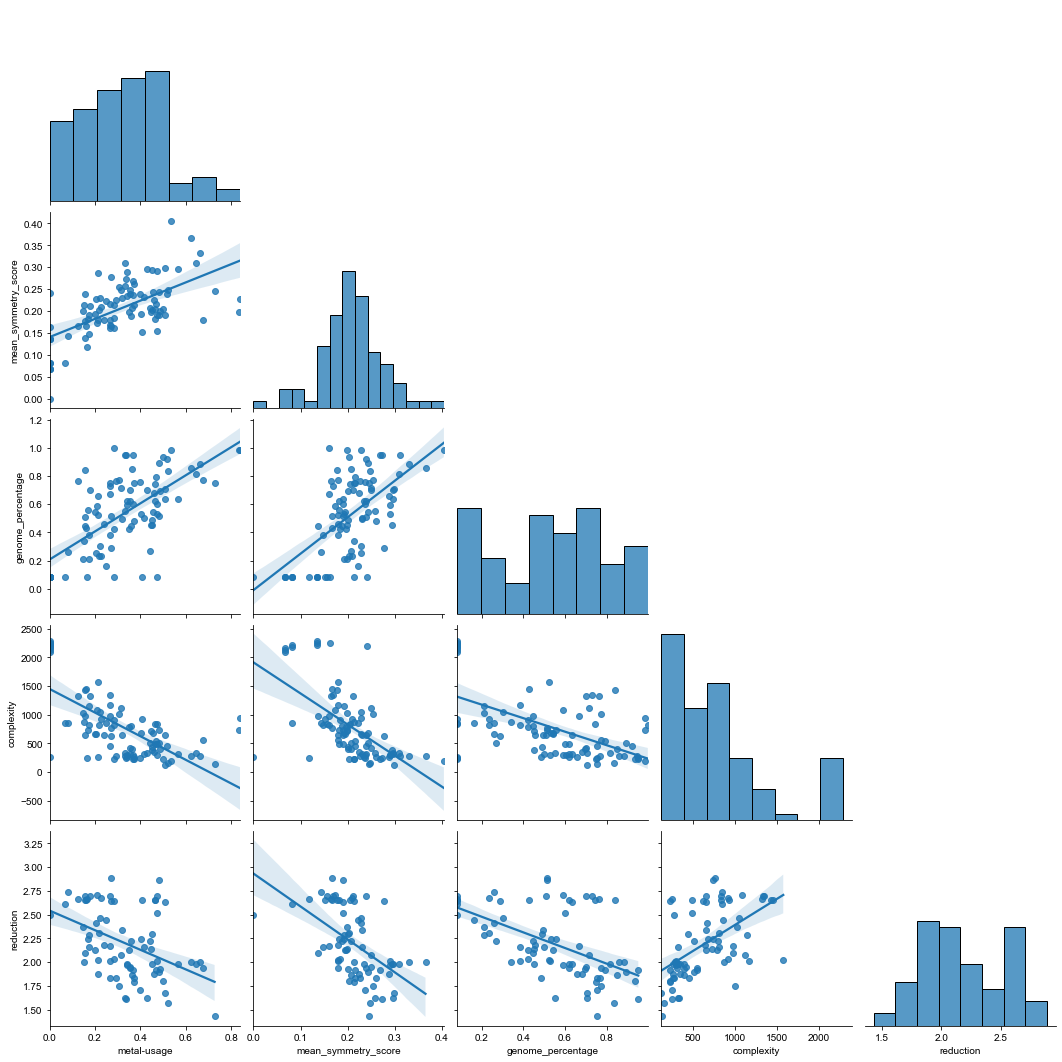

In [126]:
sns.pairplot(all_metrics,corner=True,kind="reg",size=3)

In [127]:
pg.partial_corr(data=all_metrics.reset_index(),x="iteration",y="complexity",cov=["reduction"])

,n,r,CI95%,p-val
pearson,96,0.706802,"[0.59, 0.79]",8.505245e-16


In [128]:
pg.partial_corr(data=all_metrics.reset_index(),x="iteration",y="reduction",cov=["complexity"])

,n,r,CI95%,p-val
pearson,78,0.878337,"[0.82, 0.92]",4.510686e-26


In [60]:
#ne_cpds["C00244"]
seeds = pd.read_csv('assets/seed_set.csv')
dor = pd.read_csv("assets/keggCHOmolecules.reductionState.csv")

seed_set_base = seeds[~seeds.Type.isin(["Organic carbon"])].ID.tolist()
dg = dor.sort_values("reduction")

In [103]:
r_upper = dg.reduction.quantile(q=0.75)
r_lower = dg.reduction.quantile(q=0.25)

samples = 100
N = 21
simulations = {"mean_dor":[],"ne_size":[],"dtype":[]}

for i in range(samples):
    c_lower = dg[dg.reduction < r_lower].sample(N).cid.tolist()
    s = c_lower + seed_set_base
    nec,ner = metabolism.expand(s,algorithm='naive')
    r = dg[dg.cid.isin(c_lower)].reduction.mean()
    simulations["mean_dor"].append(r)
    simulations["ne_size"].append(len(nec))
    simulations["dtype"].append("lower")

    
for i in range(samples):
    c_upper = dg[dg.reduction > r_upper].sample(N).cid.tolist()
    s = c_upper + seed_set_base
    nec,ner = metabolism.expand(s,algorithm='naive')
    r = dg[dg.cid.isin(c_upper)].reduction.mean()
    simulations["mean_dor"].append(r)
    simulations["ne_size"].append(len(nec))
    simulations["dtype"].append("higher")
    
simulations = pd.DataFrame(simulations)

In [106]:
simulations

,mean_dor,ne_size,dtype
0,1.966761,431,lower
1,1.987583,98,lower
2,1.922654,399,lower
3,1.946290,395,lower
4,1.960367,390,lower
...,...,...,...
195,2.706343,395,higher
196,2.726005,72,higher
197,2.725746,75,higher
198,2.762456,70,higher


<AxesSubplot:xlabel='mean_dor', ylabel='ne_size'>

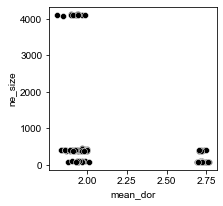

In [118]:
plt.figure(figsize=(3,3))
sns.scatterplot(x="mean_dor",y="ne_size",data=simulations,color="k")

In [132]:
len(simulations[simulations.ne_size > 3000])

14

In [133]:
from scipy.stats import fisher_exact

In [135]:
fisher_exact([[14,100-14],[0,100]])

(inf, 7.490634977462603e-05)